# Estimating $f$-DP Curve for the Subsampling Mechanism using the PTLR Estimator

## Description

This notebook demonstrates how to use the PTLR estimator API to estimate the entire $f$-DP curve for the DifferentialllyPrivate Subsampling Mechanism.

In [1]:
import numpy as np
import os
import sys
import time
import logging
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.interpolate import interp1d

# Navigate to the parent directory of the project structure
project_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
src_dir = os.path.join(project_dir, 'src')
log_dir = os.path.join(project_dir, 'log')
fig_dir = os.path.join(project_dir, 'fig')
os.makedirs(fig_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)
logfile_path = os.path.join(log_dir, 'tradeoff-Subsampling.log')

# Add the src directory to sys.path
sys.path.append(src_dir)

import mech.Subsampling as SubsamplingModule

In [2]:
kwargs = SubsamplingModule.generate_params(num_samples = 100000, h=0.1)
estimator = SubsamplingModule.SubsamplingPTLREstimator(kwargs)

In [3]:
output = estimator.build(eta_max = 15)

alpha = output["alpha"]
beta = output["beta"]

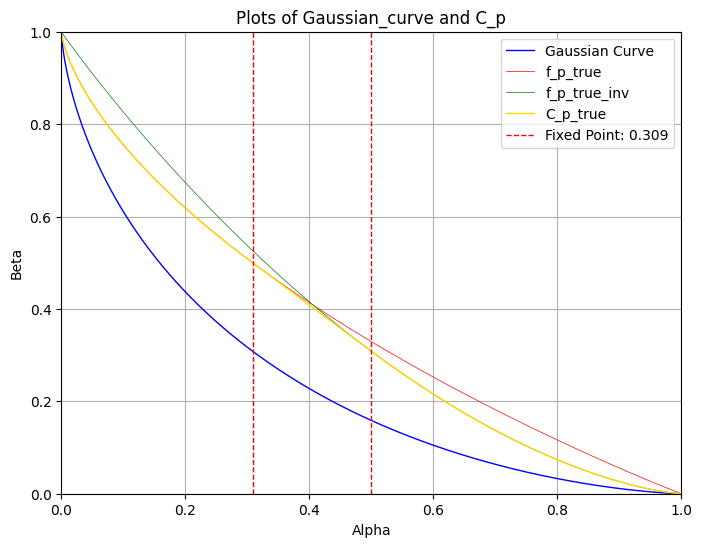

In [4]:
#sampling
n = len(kwargs["dataset"]["x0"])
m = kwargs["ss_alg"]["m"]
p = m / n

mu = 1  # sense = 1 implies mu = 1
# Define Gaussian_curve function
def Gaussian_curve(alpha):
    return norm.cdf(norm.ppf(1 - alpha) - mu)

# Define f_p_true function
def f_p_true(alpha):
    return p * Gaussian_curve(alpha) + (1 - p) * (1 - alpha)

# Generate alpha values
alpha_values = np.linspace(0, 1, 1000)

# Compute Gaussian_curve and f_p_true values
gauss_values = Gaussian_curve(alpha_values)
f_p_values_true = f_p_true(alpha_values)

# Create inverse function of f_p_true using interpolation
f_p_true_inv = interp1d(f_p_values_true, alpha_values, bounds_error=False, fill_value="extrapolate")

# Generate beta values for the inverse function
beta_values = np.linspace(min(f_p_values_true), max(f_p_values_true), 10000)
alpha_approx = f_p_true_inv(beta_values)

# Fixed point calculation
def fixed_point(x):
    return Gaussian_curve(x) - x

# Estimate the fixed point numerically
from scipy.optimize import root_scalar
fix_point = root_scalar(fixed_point, bracket=[0, 1]).root

# Define C_p_true function
def C_p_true(x, fix_x=fix_point):
    if x <= fix_x:
        return f_p_true(x)
    elif fix_x < x <= f_p_true_inv(fix_x):
        return fix_x + f_p_true(fix_x) - x
    else:
        return f_p_true_inv(x)

# Compute C_p_true values
C_p_values_true = np.array([C_p_true(alpha, fix_x=fix_point) for alpha in alpha_values])

# Prepare data for plotting
plot_data = {
    "alpha": alpha_values,
    "Gaussian_curve": gauss_values,
    "f_p_true": f_p_values_true
}

inv_data = {
    "x": beta_values,
    "f_p_true_inv": alpha_approx
}

C_p_data_true = {
    "x": alpha_values,
    "c_p": C_p_values_true
}

plt.figure(figsize=(8, 6))

# Plot Gaussian_curve
plt.plot(plot_data["alpha"], plot_data["Gaussian_curve"], color="blue", linewidth=1, label="Gaussian Curve")

# Plot f_p_true
plt.plot(plot_data["alpha"], plot_data["f_p_true"], color="red", linewidth=0.5, label="f_p_true")

# Plot f_p_true_inv
plt.plot(inv_data["x"], inv_data["f_p_true_inv"], color="green", linewidth=0.5, label="f_p_true_inv")

# Plot C_p_true
plt.plot(C_p_data_true["x"], C_p_data_true["c_p"], color="gold", linewidth=1, label="C_p_true")

# Add vertical dashed lines for the fixed point
plt.axvline(x=fix_point, color="red", linestyle="--", linewidth=1, label=f"Fixed Point: {fix_point:.3f}")
plt.axvline(x=f_p_true(fix_point), color="red", linestyle="--", linewidth=1)

# Plot aesthetics
plt.xlabel("Alpha")
plt.ylabel("Beta")
plt.title("Plots of Gaussian_curve and C_p")
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend()
plt.grid()
plt.show()


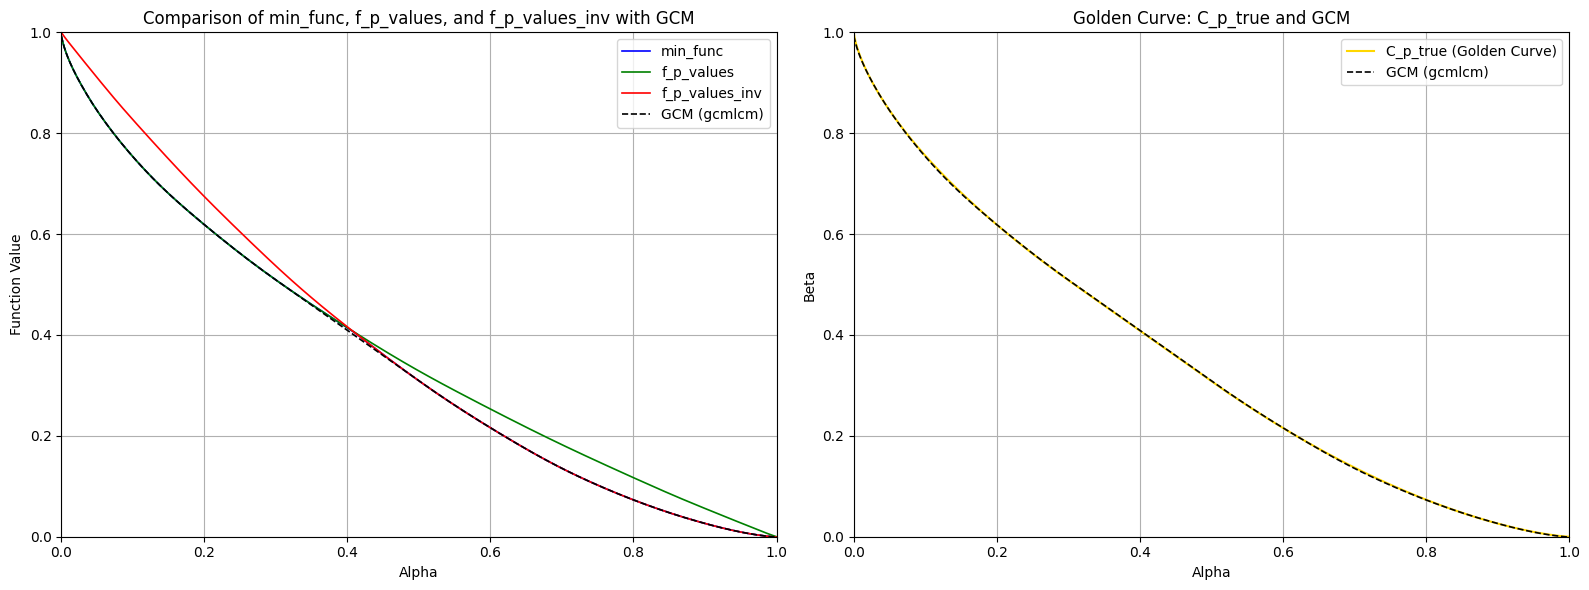

In [7]:
import pandas as pd
from rpy2.robjects import FloatVector, pandas2ri
from rpy2.robjects.packages import importr
from scipy.interpolate import interp1d
from scipy.stats import norm
from scipy.optimize import root_scalar

# Activate pandas2ri for DataFrame conversion between Python and R
pandas2ri.activate()

# Load the necessary R packages
fdrtool = importr('fdrtool')

# Convert output_df to a DataFrame
output_df = pd.DataFrame(output)

# Step 1: Remove duplicate alpha values
output_df_unique = output_df.drop_duplicates(subset="alpha")

# Step 2: Create interpolation functions for f_p_values and f_p_values_inv
f_p_values = interp1d(output_df_unique["alpha"], output_df_unique["beta"], fill_value="extrapolate")
f_p_values_inv = interp1d(output_df_unique["beta"], output_df_unique["alpha"], fill_value="extrapolate")

# Step 3: Define min_func to compute the minimum of f_p_values and f_p_values_inv
def min_func(x):
    return np.minimum(f_p_values(x), f_p_values_inv(x))

# Step 4: Generate alpha values for computation
alpha_vals = np.linspace(0, 1, 10000)

# Step 5: Compute min_func values
min_func_vals = min_func(alpha_vals)

# Step 6: Convert data to R vectors for gcmlcm
r_alpha_vals = FloatVector(alpha_vals)
r_min_func_vals = FloatVector(min_func_vals)

# Step 7: Call the gcmlcm function from the fdrtool package
gcmlcm_result = fdrtool.gcmlcm(r_alpha_vals, r_min_func_vals)

# Step 8: Extract the result from the gcmlcm output
gcmlcm_x = np.array(gcmlcm_result.rx2('x.knots'))
gcmlcm_y = np.array(gcmlcm_result.rx2('y.knots'))

# Step 9: Compute f_p_values and f_p_values_inv for plotting
f_p_values_vals = f_p_values(alpha_vals)
f_p_values_inv_vals = f_p_values_inv(alpha_vals)

# Step 10: Create a DataFrame for plotting
plot_data = pd.DataFrame({
    "x": np.tile(alpha_vals, 3),
    "y": np.concatenate([min_func_vals, f_p_values_vals, f_p_values_inv_vals]),
    "function_name": np.repeat(["min_func", "f_p_values", "f_p_values_inv"], len(alpha_vals))
})

# Create a DataFrame for gcmlcm result
gg_data = pd.DataFrame({
    "x": gcmlcm_x,
    "y": gcmlcm_y
})

# --- Golden Curve Computation ---
# Define parameters
mu = 1  # sense = 1 implies mu = 1

p = m / n

# Define Gaussian_curve function
def Gaussian_curve(alpha):
    return norm.cdf(norm.ppf(1 - alpha) - mu)

# Define f_p_true function
def f_p_true(alpha):
    return p * Gaussian_curve(alpha) + (1 - p) * (1 - alpha)

# Fixed point calculation
def fixed_point(x):
    return Gaussian_curve(x) - x

fix_point = root_scalar(fixed_point, bracket=[0, 1]).root

# Define C_p_true function
def C_p_true(x, fix_x=fix_point):
    if x <= fix_x:
        return f_p_true(x)
    elif fix_x < x <= f_p_true_inv(fix_x):
        return fix_x + f_p_true(fix_x) - x
    else:
        return f_p_true_inv(x)

# Generate alpha values for golden curve
alpha_values = np.linspace(0, 1, 1000)
gauss_values = Gaussian_curve(alpha_values)
f_p_values_true = f_p_true(alpha_values)
f_p_true_inv = interp1d(f_p_values_true, alpha_values, bounds_error=False, fill_value="extrapolate")
C_p_values_true = np.array([C_p_true(alpha, fix_x=fix_point) for alpha in alpha_values])

# Create DataFrame for golden curve
C_p_data_true = pd.DataFrame({
    "x": alpha_values,
    "c_p": C_p_values_true
})

# --- Plotting ---

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot 1: min_func, f_p_values, f_p_values_inv, and GCM ---
for func_name, color in zip(["min_func", "f_p_values", "f_p_values_inv"], ["blue", "green", "red"]):
    subset = plot_data[plot_data["function_name"] == func_name]
    axes[0].plot(subset["x"], subset["y"], label=func_name, color=color, linewidth=1.2)

# Plot the GCM result from gcmlcm (dashed black line)
axes[0].plot(gg_data["x"], gg_data["y"], label="GCM (gcmlcm)", color="black", linestyle="--", linewidth=1.2)

# Plot aesthetics for first plot
axes[0].set_title("Comparison of min_func, f_p_values, and f_p_values_inv with GCM")
axes[0].set_xlabel("Alpha")
axes[0].set_ylabel("Function Value")
axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 1)
axes[0].legend()
axes[0].grid(True)

# --- Plot 2: Golden Curve and GCM ---
axes[1].plot(C_p_data_true["x"], C_p_data_true["c_p"], color="gold", linewidth=1.5, label="C_p_true (Golden Curve)")

# Plot the GCM result from gcmlcm (dashed black line)
axes[1].plot(gg_data["x"], gg_data["y"], label="GCM (gcmlcm)", color="black", linestyle="--", linewidth=1.2)

# Plot aesthetics for second plot
axes[1].set_title("Golden Curve: C_p_true and GCM")
axes[1].set_xlabel("Alpha")
axes[1].set_ylabel("Beta")
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)
axes[1].legend()
axes[1].grid(True)

# Show the plots
plt.tight_layout()
plt.show()
